# 0.0 IMPORTS

In [34]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import inflection
import xgboost as xgb
import warnings
import pickle
import random
import warnings

from boruta                import BorutaPy
from tabulate              import tabulate
from scipy                 import stats as ss
from matplotlib            import pyplot as plt
from IPython.core.display  import HTML
from IPython.core.display  import Image

from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble      import RandomForestRegressor
from sklearn.ensemble      import RandomForestClassifier
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

warnings.filterwarnings( 'ignore' )

### 0.1 Helper Functions

In [109]:
def cross_validation( model_name, model, cv=5):
    
    # model
    scoring = ['neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_root_mean_squared_error']
    cv=5
    m_result_cv = cross_validate(model, X_train, y_train, cv=5, scoring=scoring)
    
    # perfomance
    mae =  np.round ( np.mean( m_result_cv['test_neg_mean_absolute_error']), 4).astype(str)  + ' +- ' + ( np.round (np.std( m_result_cv['test_neg_mean_absolute_error']), 4).astype(str)) 
    mape = np.round ( np.mean( m_result_cv['test_neg_mean_absolute_percentage_error']), 4).astype(str)  + ' +- ' + ( np.round (np.std( m_result_cv['test_neg_mean_absolute_percentage_error']), 4).astype(str)) 
    rmse = np.round ( np.mean( m_result_cv['test_neg_root_mean_squared_error']), 4).astype(str)  + ' +- ' + ( np.round (np.std( m_result_cv['test_neg_root_mean_squared_error']), 4).astype(str)) 
    # result
    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse}, index=[0])

def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y )

def mean_absolute_percentage_error( y, yhat ):
    return np.mean( np.abs( ( y - yhat ) / y ) )

def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    return pd.DataFrame( { 'Model Name': model_name,
                           'MAE': mae,
                           'MAPE': mape,
                           'RMSE': rmse }, index=[0] )

def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) ) 
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

def jupyter_settings(): 
    %matplotlib inline 
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [24, 20]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') ) 
    pd.options.display.max_columns = None
    pd.options.display.max_rows = 1000
    pd.set_option( 'display.expand_frame_repr', False ) 
    sns.set()
    
def fahr_to_celsius(temp_fahr):
    temp_celsius = (temp_fahr - 32) * 5 / 9
    return temp_celsius
    
jupyter_settings()   

Populating the interactive namespace from numpy and matplotlib


### 0.2 Loading Data

In [2]:
df_train_raw = pd.read_csv('../data/train.csv', low_memory=False)
df_features_raw = pd.read_csv('../data/features.csv', low_memory=False)
df_store_raw = pd.read_csv('../data/stores.csv', low_memory=False)

#merge
features_raw = df_features_raw.merge(df_store_raw, on='Store', how='inner')
df_raw = df_train_raw.merge(features_raw, on=['Store', 'Date', 'IsHoliday'], how='inner')

In [3]:
df_raw.sample()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
20332,2,92,2012-10-12,192455.74,False,60.97,3.601,2145.5,NaN,33.31,586.83,10421.01,223.015426,6.17,A,202307


# 1.0 DESCRIÇÃO DOS DADOS

In [4]:
df1 = df_raw.copy()

### 1.1 Rename Columns

In [5]:
cols_old = ['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday', 'Temperature',
       'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4',
       'MarkDown5', 'CPI', 'Unemployment', 'Type', 'Size']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map (snakecase, cols_old))

#rename
df1.columns = cols_new

In [6]:
df1.sample()

,store,dept,date,weekly_sales,is_holiday,temperature,fuel_price,mark_down1,mark_down2,mark_down3,mark_down4,mark_down5,cpi,unemployment,type,size
7829,1,13,2012-03-09,40001.72,False,58.76,3.669,10331.04,151.88,6.0,671.43,5509.84,221.059189,7.348,A,151315


### 1.2 Data Dimensions

In [7]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Cols: {}'.format(df1.shape[1]))

Number of Rows: 421570
Number of Cols: 16


### 1.3 Data Types

In [8]:
df1.dtypes

store             int64
dept              int64
date             object
weekly_sales    float64
is_holiday         bool
temperature     float64
fuel_price      float64
mark_down1      float64
mark_down2      float64
mark_down3      float64
mark_down4      float64
mark_down5      float64
cpi             float64
unemployment    float64
type             object
size              int64
dtype: object

### 1.4 Check NA

In [9]:
df1.isna().sum()

store                0
dept                 0
date                 0
weekly_sales         0
is_holiday           0
temperature          0
fuel_price           0
mark_down1      270889
mark_down2      310322
mark_down3      284479
mark_down4      286603
mark_down5      270138
cpi                  0
unemployment         0
type                 0
size                 0
dtype: int64

### 1.5 Fillout NA

In [10]:
#mark_down1      270889
df1['mark_down1'] = df1['mark_down1'].fillna(df1['mark_down1'].mean())

#mark_down2      310322
df1['mark_down2'] = df1['mark_down2'].fillna(df1['mark_down2'].mean())

#mark_down3      284479
df1['mark_down3'] = df1['mark_down3'].fillna(df1['mark_down3'].mean())

#mark_down4      286603
df1['mark_down4'] = df1['mark_down4'].fillna(df1['mark_down5'].mean())

#mark_down5      270138
df1['mark_down5'] = df1['mark_down5'].fillna(df1['mark_down5'].mean())

### 1.6 Change Types

In [11]:
df1.dtypes

store             int64
dept              int64
date             object
weekly_sales    float64
is_holiday         bool
temperature     float64
fuel_price      float64
mark_down1      float64
mark_down2      float64
mark_down3      float64
mark_down4      float64
mark_down5      float64
cpi             float64
unemployment    float64
type             object
size              int64
dtype: object

In [12]:
df1['date'] = pd.to_datetime(df1['date'])
df1['is_holiday'] = df1['is_holiday'].astype('object')

### 1.7 Descriptive Statistical

In [33]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

### 1.7.1 Numerical Attributes

In [14]:
# Central Tendency - mean, meadina
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T
# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.000,45.000000,44.000000,22.200546,22.000000,12.785282,0.077763,-1.146503
1,dept,1.000,99.000000,98.000000,44.260317,37.000000,30.492018,0.358223,-1.215571
2,weekly_sales,-4988.940,693099.360000,698088.300000,15981.258123,7612.030000,22711.156583,3.262008,21.491290
3,temperature,-2.060,100.140000,102.200000,60.090059,62.090000,18.447909,-0.321404,-0.635922
4,fuel_price,2.472,4.468000,1.996000,3.361027,3.452000,0.458514,-0.104901,-1.185405
5,mark_down1,0.270,88646.760000,88646.490000,7246.420196,7246.420196,4956.914937,5.589708,54.650395
6,mark_down2,-265.760,104519.540000,104785.300000,3334.628621,3334.628621,4867.488138,10.592147,150.807771
7,mark_down3,-29.100,141630.610000,141659.710000,1439.421384,1439.421384,5487.595084,14.729167,245.117904
8,mark_down4,0.220,67474.850000,67474.630000,4230.125992,4628.975079,3607.477324,7.546457,87.371054
9,mark_down5,135.160,108519.280000,108384.120000,4628.975079,4628.975079,3573.791065,13.631402,305.585755


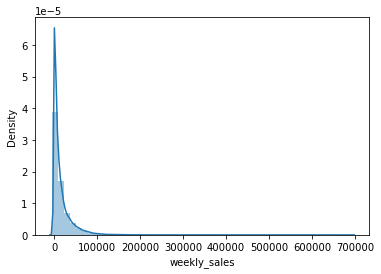

In [15]:
sns.distplot( df1['weekly_sales']);

### 1.7.2 Categorical Attributes

In [16]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

is_holiday    2
type          3
dtype: int64

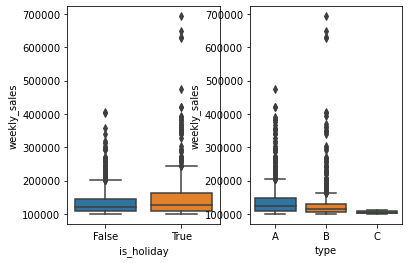

In [17]:
aux1 = df1[df1['weekly_sales'] > 100000]

plt.subplot( 1, 2, 1 );
sns.boxplot( x='is_holiday', y='weekly_sales', data=aux1 ) ;

plt.subplot( 1, 2, 2 );
sns.boxplot( x='type', y='weekly_sales', data=aux1 );

# 2.0 FEATURE ENGINEERING

In [56]:
df2 = df1.copy()

##  2.1 Mapa mental de Hipoteses

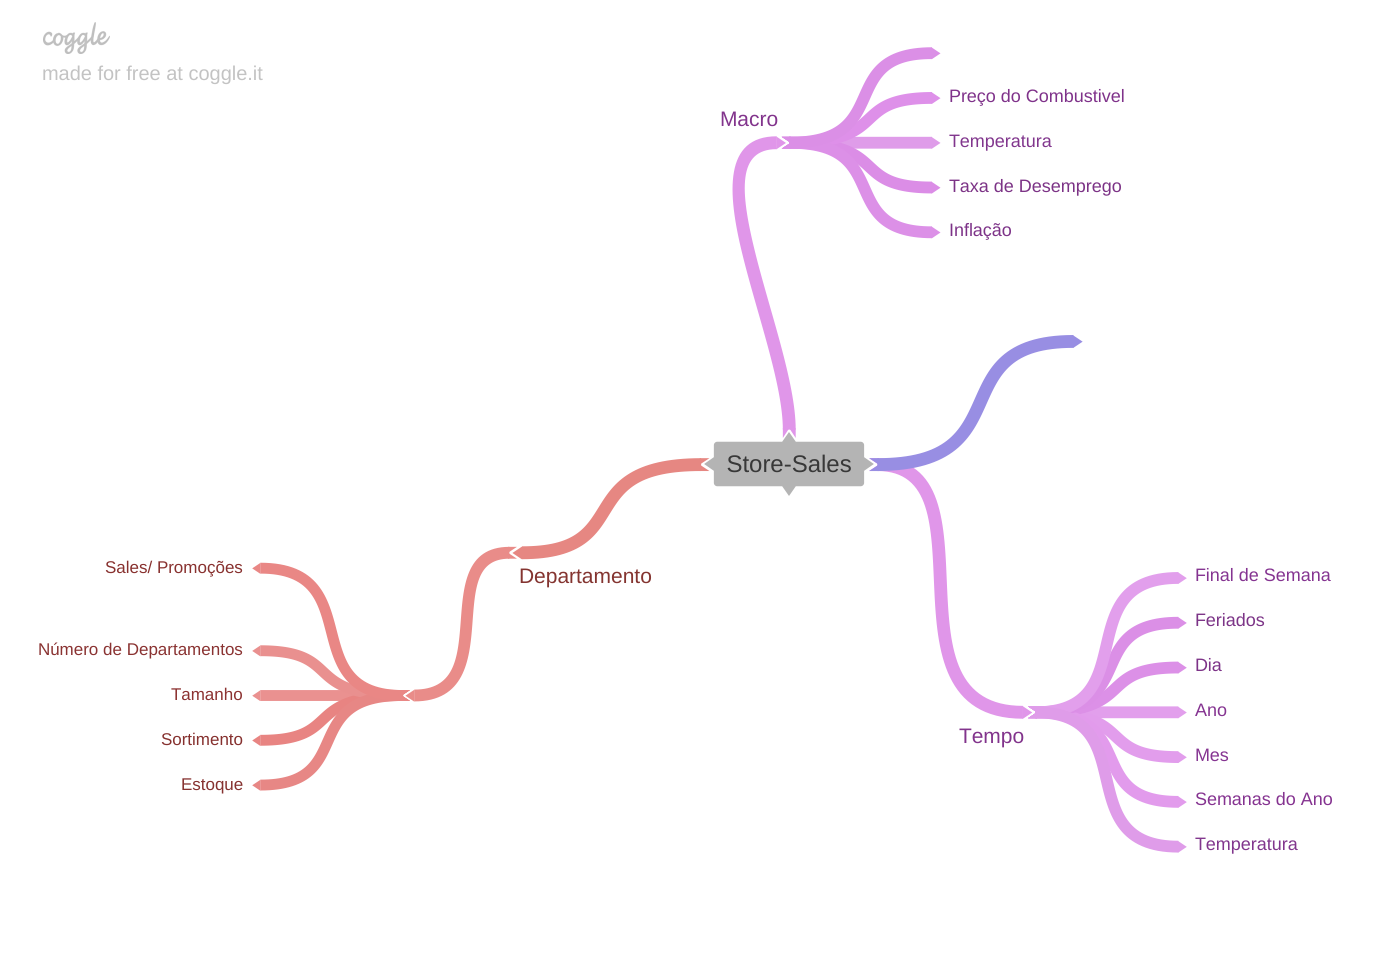

In [57]:
Image('../img/MindMapHipothesis_v3.png')

## 2.1 Criação das Hipoteses

### **2.1** Hipotese Loja

**1.** Lojas de maior tamanho deveriam vender mais.

**2.** Lojas com promoções deveriam vender mais

### 2.1 Hipotese Tempo 

**1.** Lojas deveriam vender mais aos finais de semana

**2.** Lojas deveriam vender menos aos feriados

**3.** Lojas vendem mais no primeiro semestre do ano

#### 2.1 Hipotese Macro Ambiente

**H1.** Lojas deveriam vender menos quando o preço do combustivel aumenta.

**H2.** Lojas deveriam vender mais quando a temperatura aumenta.

### 2.2 Lista final de Hipoteses

**H1.** Lojas de maior tamanho deveriam vender mais.

**H2.** Lojas com promoções deveriam vender mais


**H3.** Lojas deveriam vender mais aos finais de semana

**H4.** Lojas deveriam vender menos aos feriados

**H5.** Lojas vendem mais no primeiro semestre do ano

**H6.** Lojas deveriam vender menos quando o preço do combustivel aumenta.

**H7.** Lojas deveriam vender mais quando a temperatura aumenta.

### 2.3 Feature Engineering

In [59]:
df2

,store,dept,date,weekly_sales,is_holiday,temperature,fuel_price,mark_down1,mark_down2,mark_down3,mark_down4,mark_down5,cpi,unemployment,type,size,state_holiday
0,1,1,2010-02-05,24924.50,False,42.31,2.572,7246.420196,3334.628621,1439.421384,4628.975079,4628.975079,211.096358,8.106,A,151315,0
1,1,2,2010-02-05,50605.27,False,42.31,2.572,7246.420196,3334.628621,1439.421384,4628.975079,4628.975079,211.096358,8.106,A,151315,0
2,1,3,2010-02-05,13740.12,False,42.31,2.572,7246.420196,3334.628621,1439.421384,4628.975079,4628.975079,211.096358,8.106,A,151315,0
3,1,4,2010-02-05,39954.04,False,42.31,2.572,7246.420196,3334.628621,1439.421384,4628.975079,4628.975079,211.096358,8.106,A,151315,0
4,1,5,2010-02-05,32229.38,False,42.31,2.572,7246.420196,3334.628621,1439.421384,4628.975079,4628.975079,211.096358,8.106,A,151315,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,93,2012-10-26,2487.80,False,58.85,3.882,4018.910000,58.080000,100.000000,211.940000,858.330000,192.308899,8.667,B,118221,0
421566,45,94,2012-10-26,5203.31,False,58.85,3.882,4018.910000,58.080000,100.000000,211.940000,858.330000,192.308899,8.667,B,118221,0
421567,45,95,2012-10-26,56017.47,False,58.85,3.882,4018.910000,58.080000,100.000000,211.940000,858.330000,192.308899,8.667,B,118221,0
421568,45,97,2012-10-26,6817.48,False,58.85,3.882,4018.910000,58.080000,100.000000,211.940000,858.330000,192.308899,8.667,B,118221,0


In [64]:
df2['state_holiday'] = 0

df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'super_bowl' if (df2['is_holiday'] == 'True') & (df2['week_of_year'] == 6) else 'regular_day')
                        
    #elif (df2.loc[i, 'is_holiday']== 1) & (df2.loc[i, 'week_of_year'] == 36):
    #      df2.loc[i, 'state_holiday'] = 'labor_day'
    #            
    #elif (df2.loc[i, 'is_holiday']== 1) & (df2.loc[i, 'week_of_year'] == 47):
    #     df2.loc[i, 'state_holiday'] = 'thanks_giving'   
    #             
    #elif (df2.loc[i, 'is_holiday']== 1) & (df2.loc[i, 'week_of_year'] == 52):
    #     df2.loc[i, 'state_holiday'] = 'christimas'
                           #
#
 #   else:
  #      df2.loc[i, 'state_holiday'] = 'regular_day'

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [62]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

#temperature
df2['temperature'] = fahr_to_celsius(df2["temperature"])

# 3.0 FILTRAGEM DAS VARIÁVEIS

In [65]:
df3 = df2.copy()

### 3.1 Filtragem das Linha

In [66]:
df3 = df3[df3['weekly_sales'] > 0]

# 4.0 ANALISE EXPLORATÓRIA DOS DADOS

In [67]:
df4 = df3.copy()

## 4.1 Analise Univariada

### 4.1.2 Response  Variable

<AxesSubplot:xlabel='weekly_sales'>

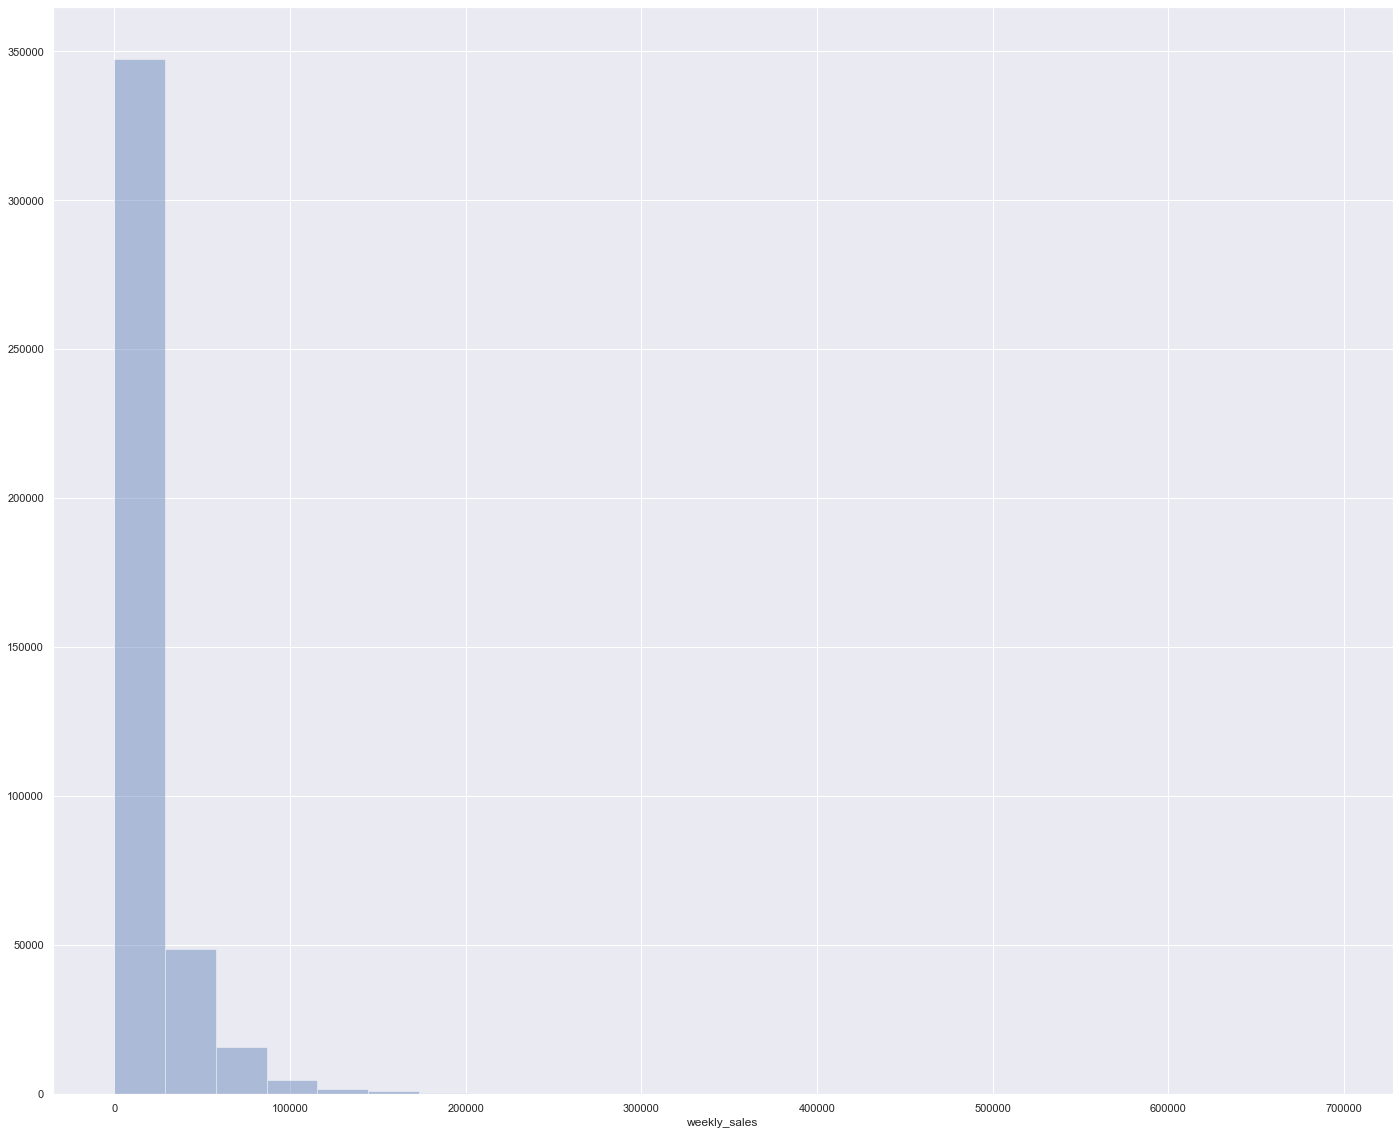

In [68]:
sns.distplot(df4['weekly_sales'] , bins=24, kde= False)

### 4.1.3 Numerical Variables

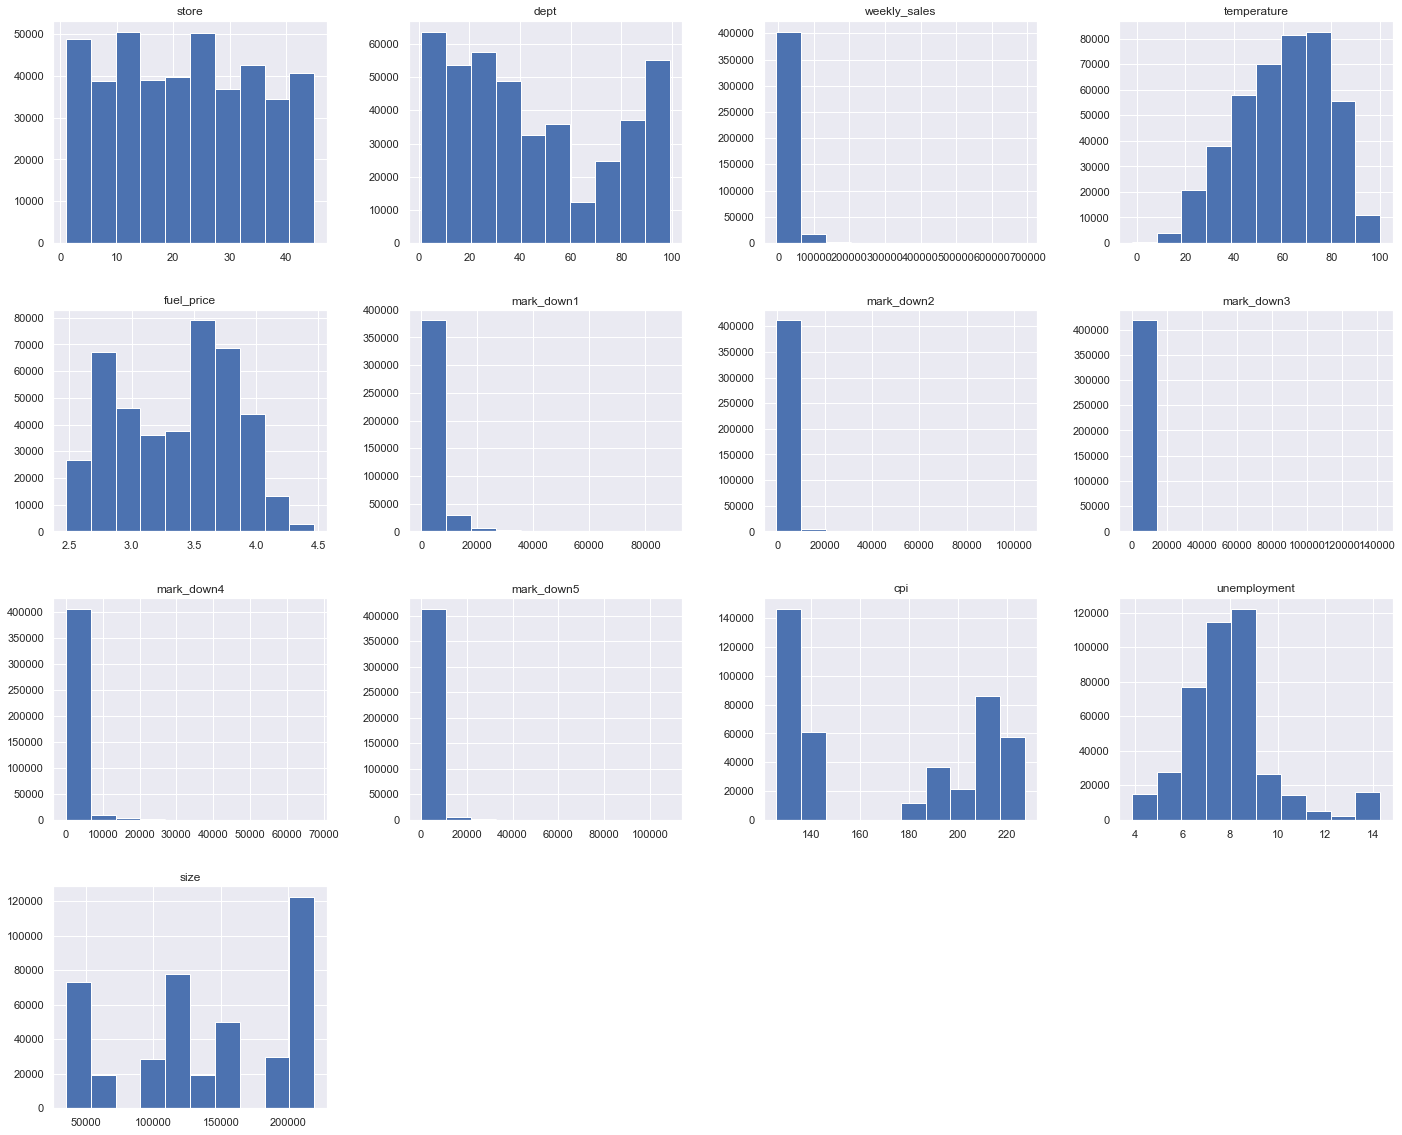

In [69]:
num_attributes.hist();

### 4.1.4 Categorical Variables

<AxesSubplot:xlabel='is_holiday', ylabel='count'>

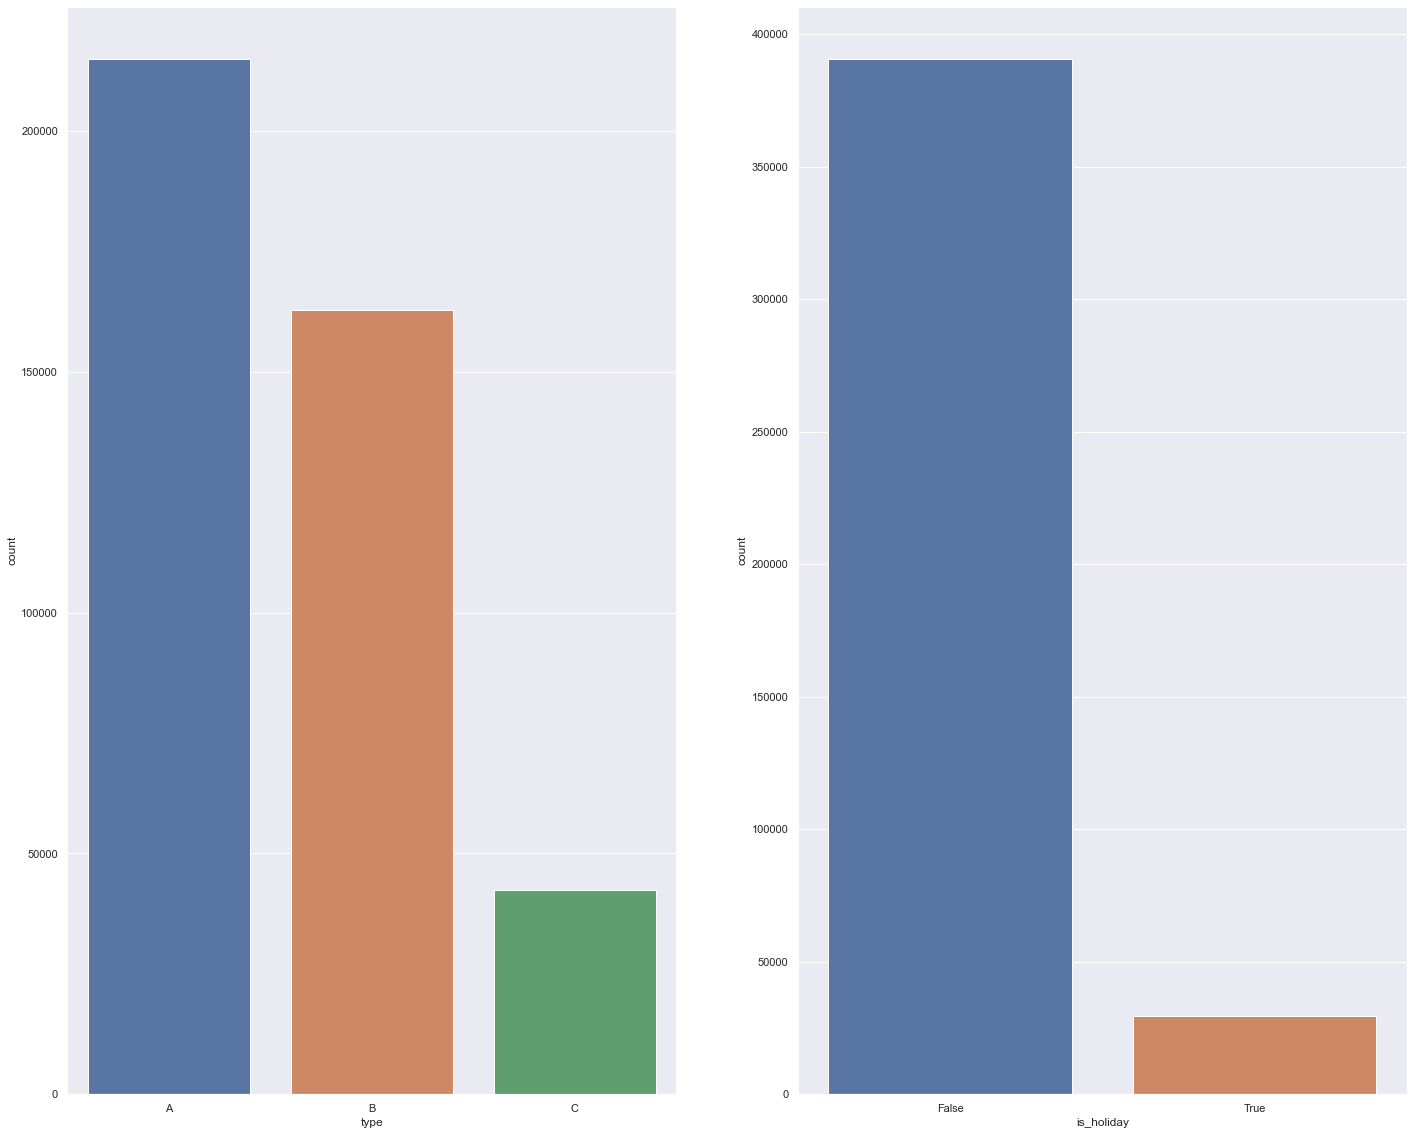

In [70]:
df4['type'].drop_duplicates()
df4['is_holiday'].drop_duplicates()

# type
plt.subplot(1,2, 1)
sns.countplot(df4['type'])

# is_holiday
plt.subplot(1,2, 2)
sns.countplot(df4['is_holiday'])

## 4.2 Analise Bivariada

### **H1.** Lojas de maior tamanho deveriam vender mais.

**VERDADEIRO** Lojas com maiores tamanho vendem mais.

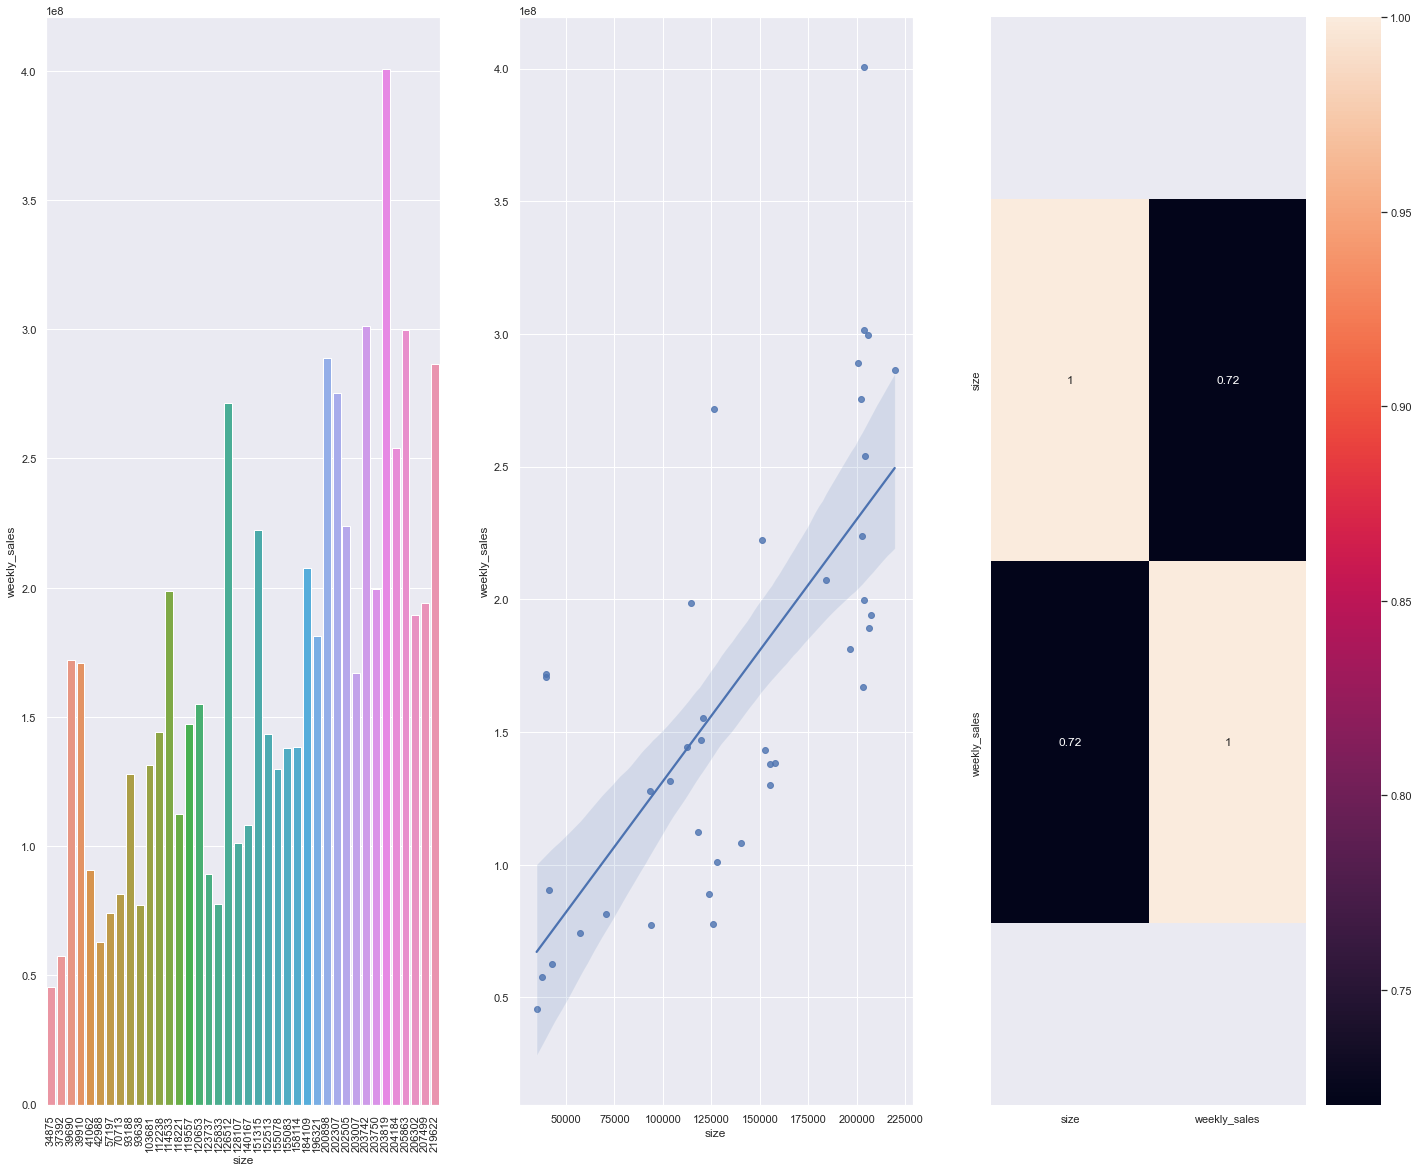

In [71]:
plt.subplot( 1, 3, 1 )
aux1 = df4[['size', 'weekly_sales']].groupby( 'size' ).sum().reset_index()
sns.barplot( x='size', y='weekly_sales', data=aux1 );
plt.xticks( rotation=90 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='size', y='weekly_sales', data=aux1 );

plt.subplot( 1, 3, 3 )
x = sns.heatmap( aux1.corr( method='pearson'), annot=True );
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5);


### **H4.** Lojas deveriam vender mais no inicio do mês
**VERDADEIRA** Lojas vendem mais no inicio do mês.

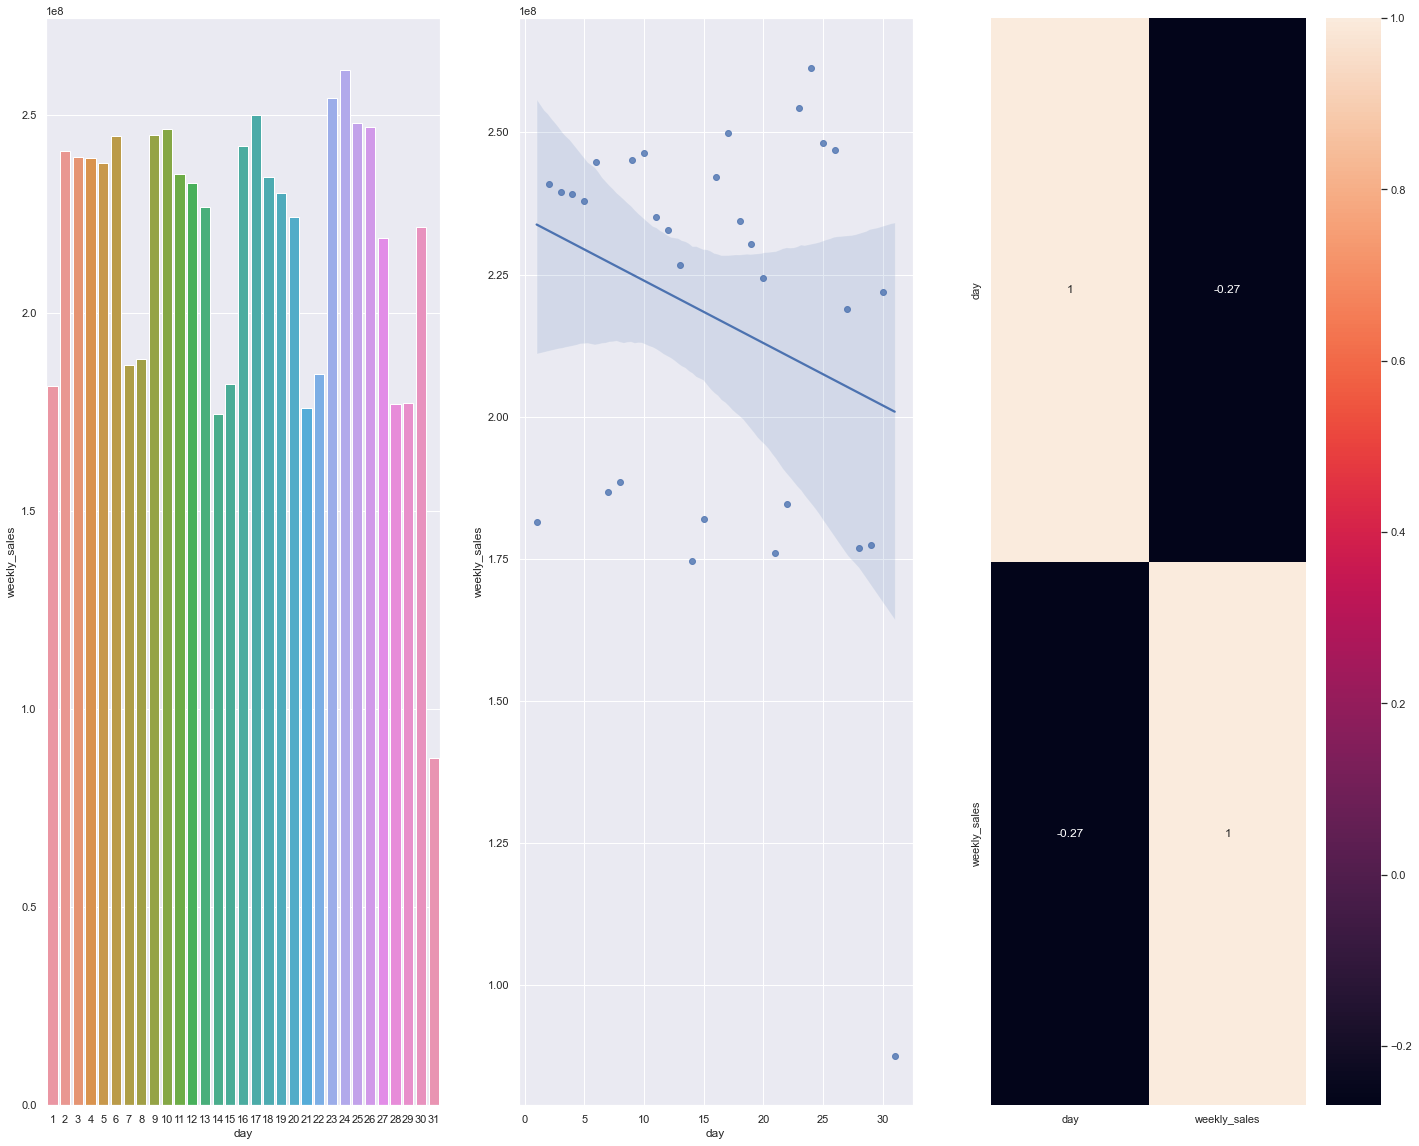

In [72]:
aux1 = df4[['day', 'weekly_sales']].groupby( 'day' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='day', y='weekly_sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='day', y='weekly_sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### **H5.** Lojas deveriam vender menos aos feriados
**VERDADEIRO** Lojas vendem menos aos feriados. 

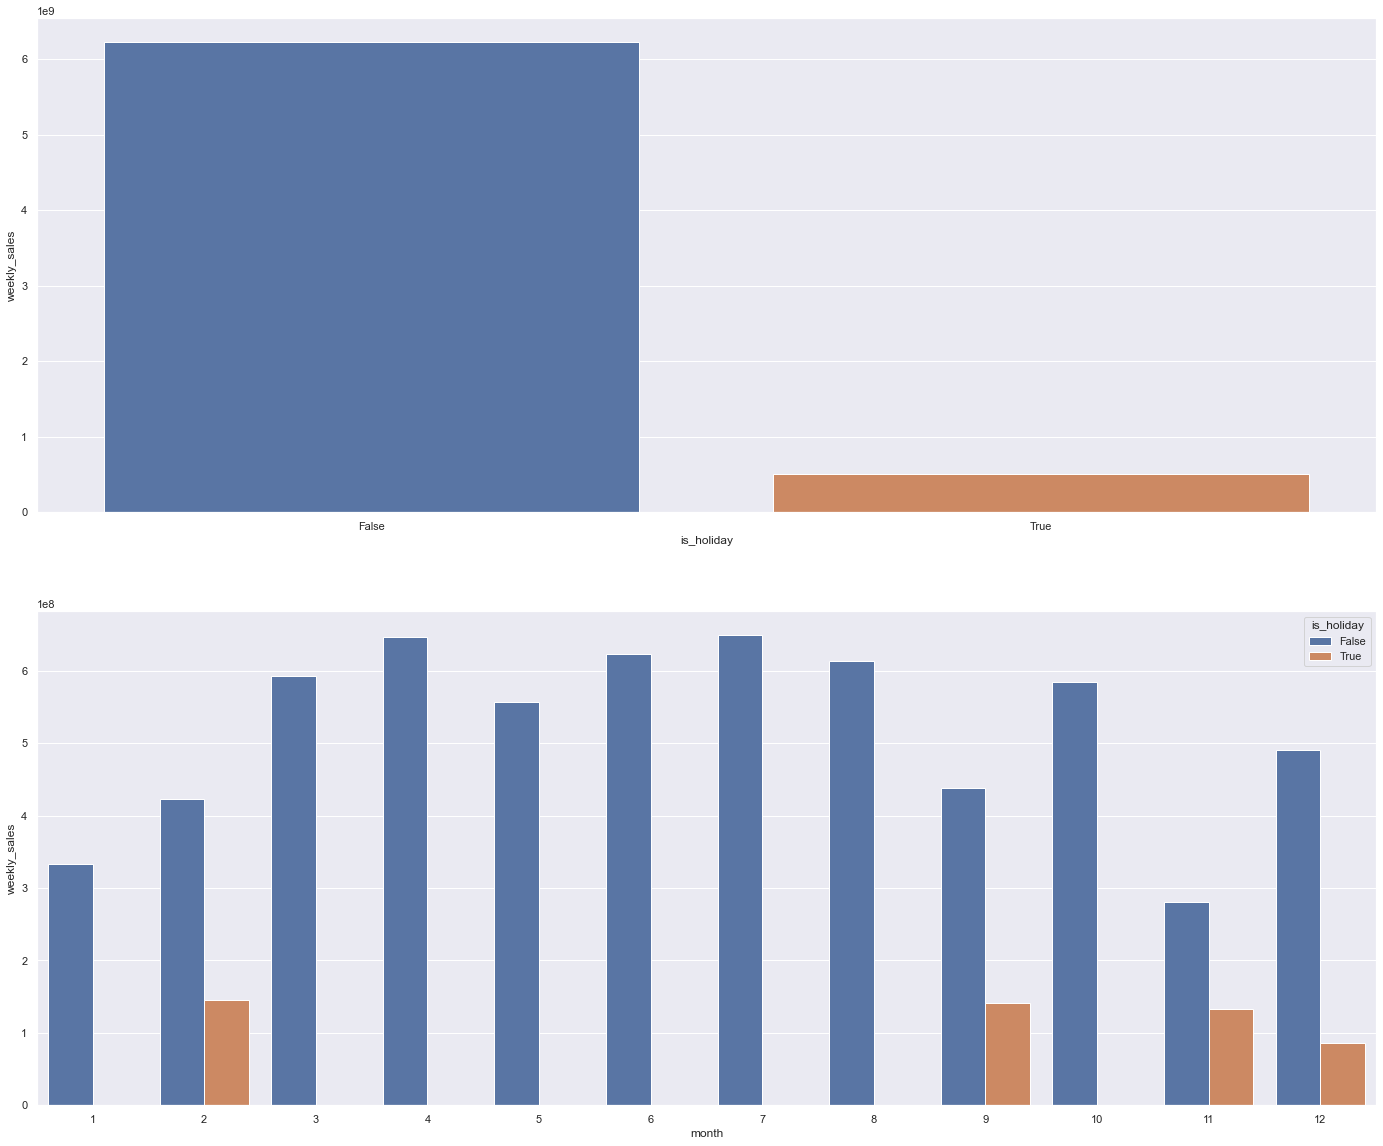

In [73]:
plt.subplot( 2, 1, 1 )
aux1 = df4[['is_holiday', 'weekly_sales']].groupby( 'is_holiday' ).sum().reset_index()
sns.barplot( x='is_holiday', y='weekly_sales', data=aux1 );

plt.subplot( 2, 1, 2 )
aux2 = df4[['is_holiday', 'weekly_sales', 'month']].groupby( ['month', 'is_holiday'] ).sum().reset_index()
sns.barplot( x='month', y='weekly_sales', hue='is_holiday',  data=aux2);

### **H6.** Lojas vendem mais no primeiro semestre do ano
**FALSA** Lojas vendem mais no segundo semestre do ano.

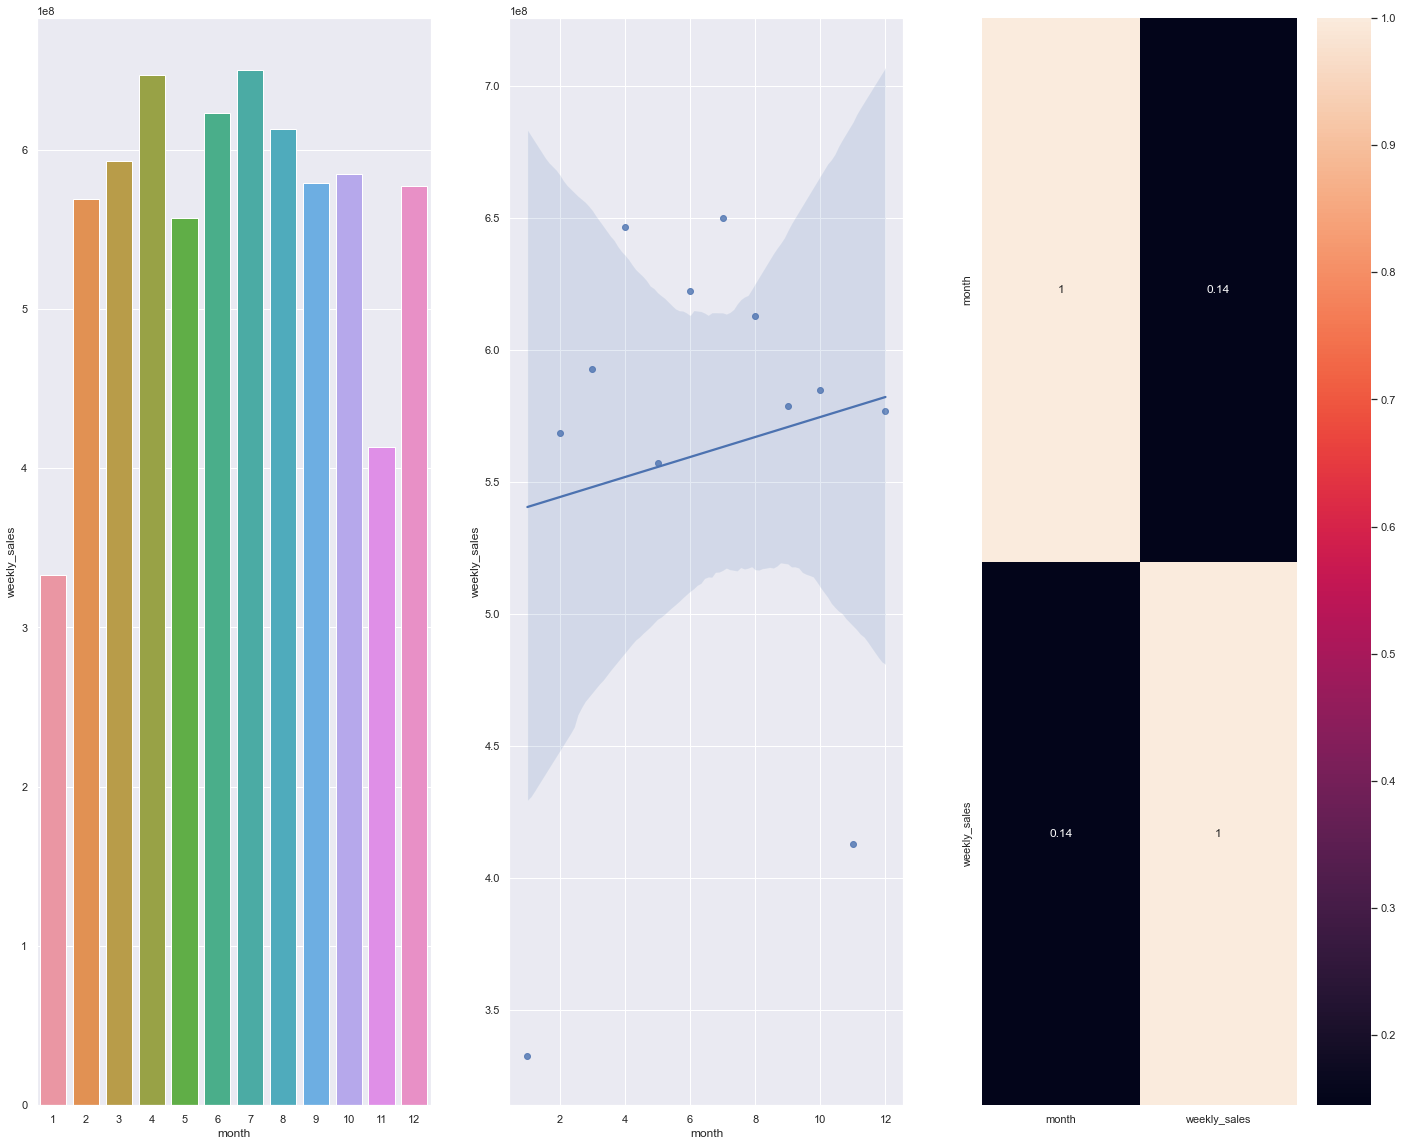

In [74]:
aux1 = df4[['month', 'weekly_sales']].groupby( 'month' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='month', y='weekly_sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='month', y='weekly_sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### **H7.** Lojas deveriam vender menos quando o preço do combustivel aumenta.

**FALSO** Lojas vendem mais quando o preço do combustivel aumenta.

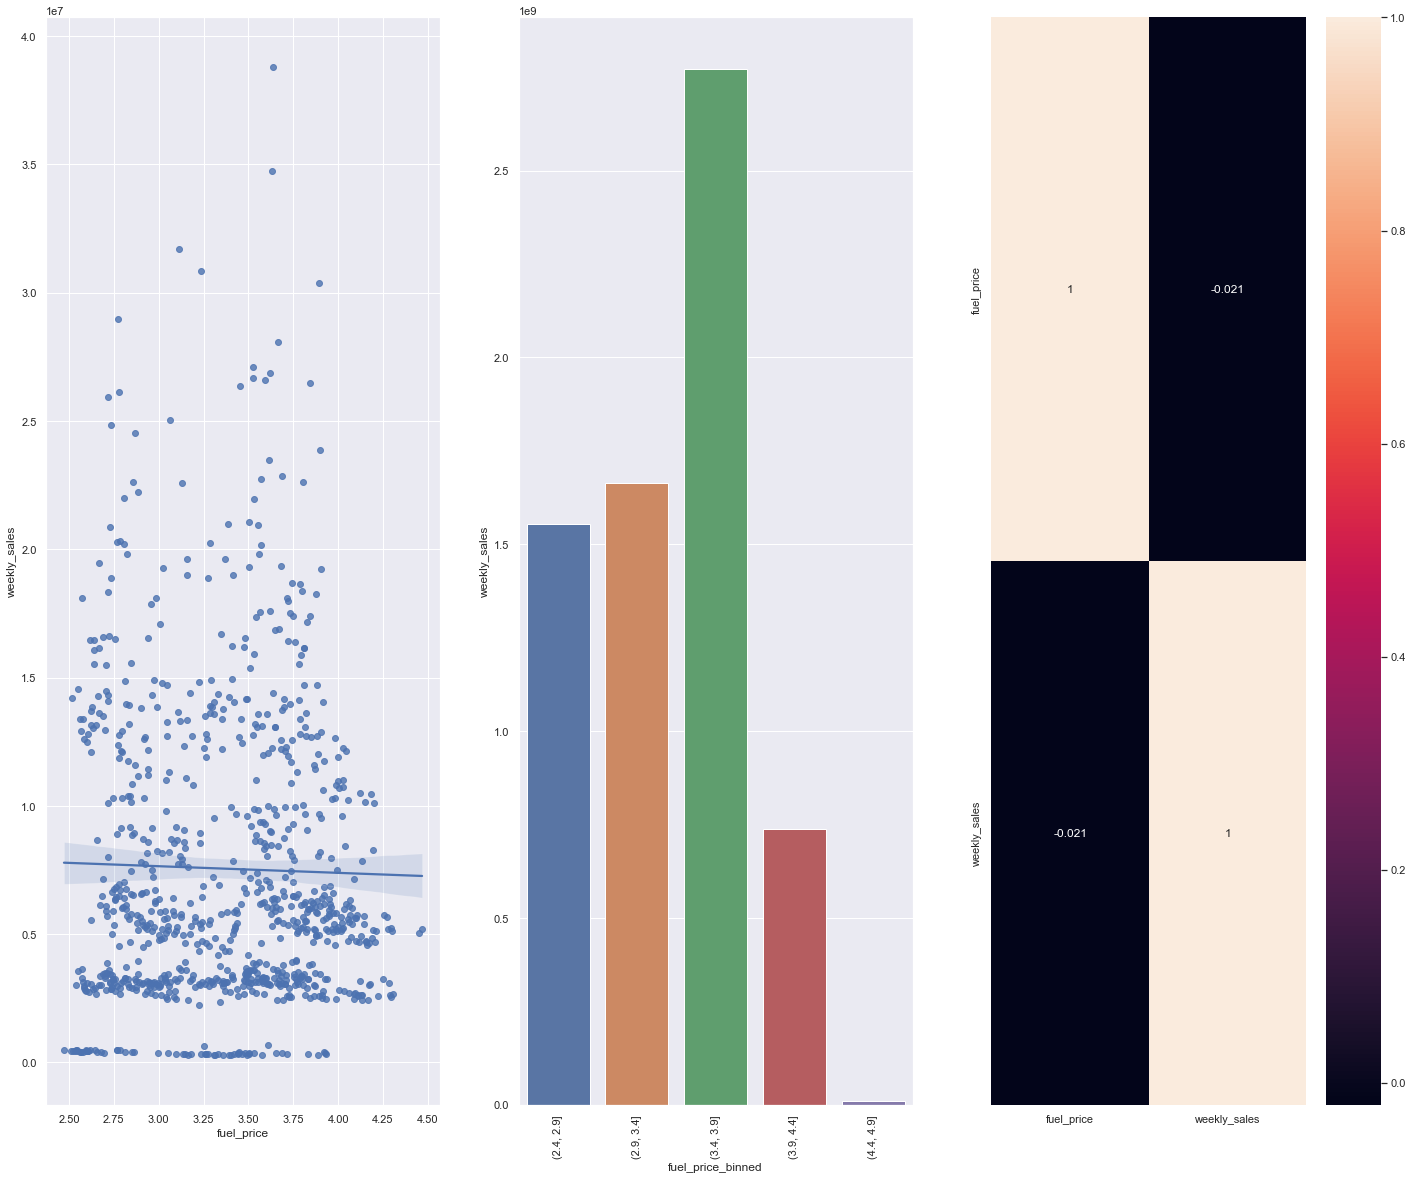

In [75]:
aux1 = df4[['fuel_price', 'weekly_sales']].groupby('fuel_price').sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.regplot( x='fuel_price', y='weekly_sales', data=aux1 );

plt.subplot( 1, 3, 2 )
bins = list( np.arange( 2.4, 5, 0.5) )
aux1['fuel_price_binned'] = pd.cut( aux1['fuel_price'], bins=bins )
aux2 = aux1[['fuel_price_binned', 'weekly_sales']].groupby('fuel_price_binned' ).sum().reset_index()
sns.barplot( x='fuel_price_binned', y='weekly_sales', data=aux2 ); 
plt.xticks( rotation=90 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### **H8.** Lojas deveriam vender mais quando a temperatura aumenta.

**VERDADEIRA** Lojas vendem mais quando a temperatura aumenta.

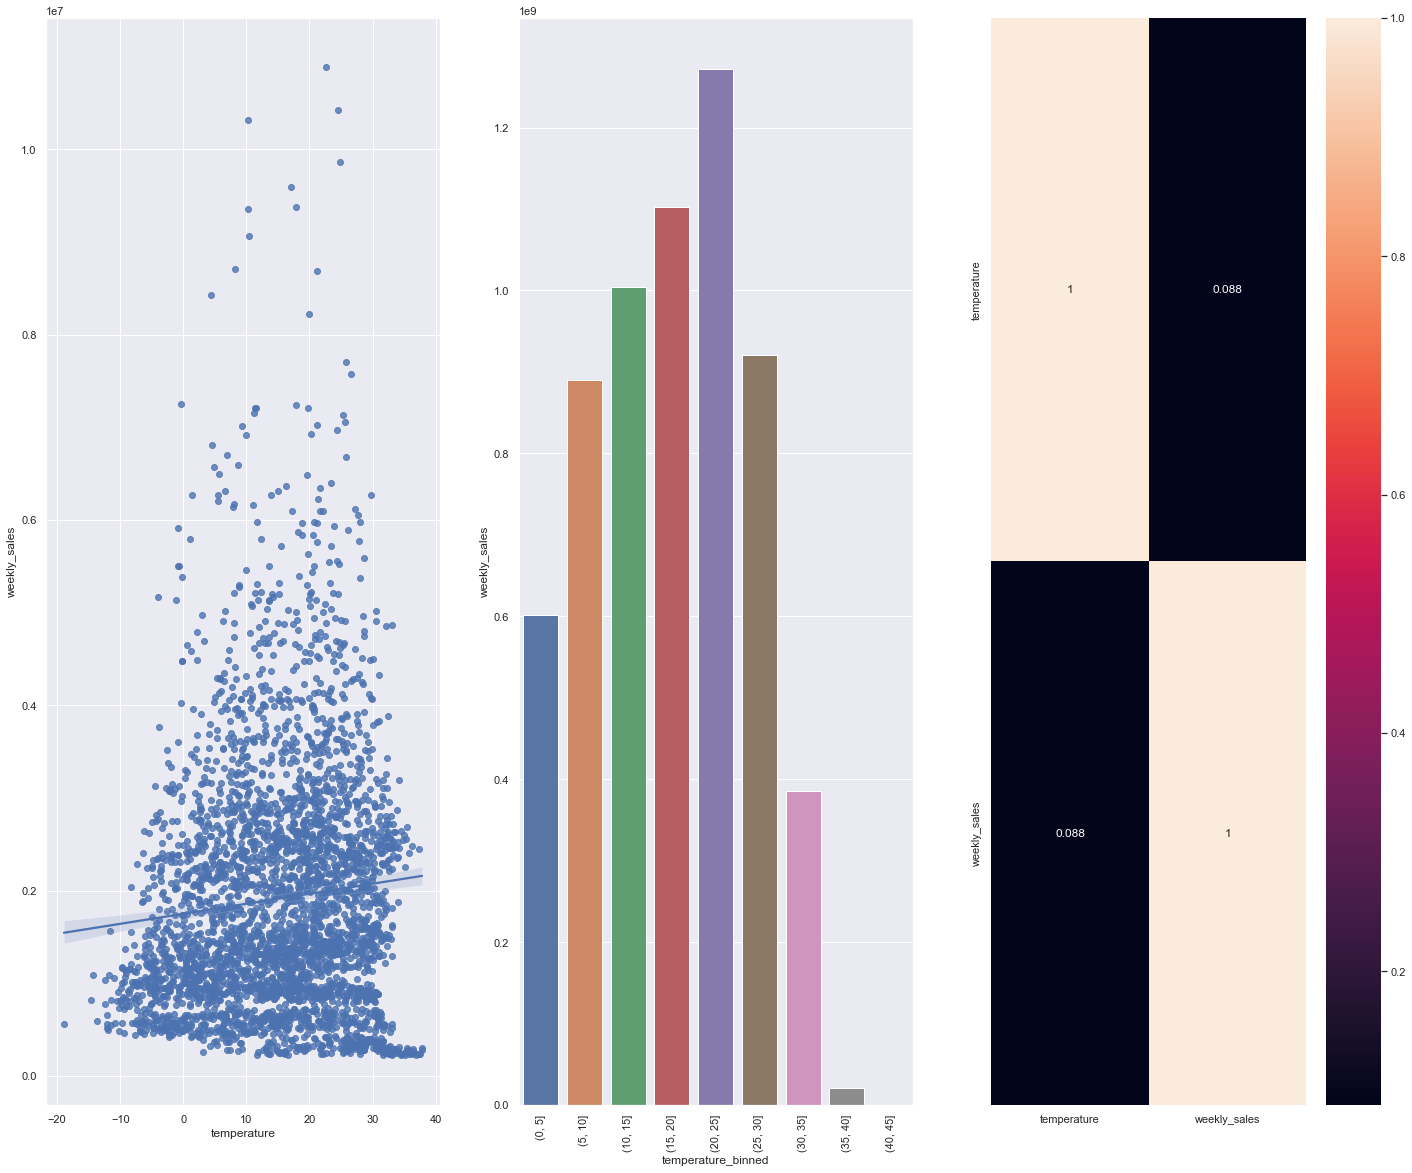

In [76]:
aux1 = df4[['temperature', 'weekly_sales']].groupby('temperature').sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.regplot( x='temperature', y='weekly_sales', data=aux1 );

plt.subplot( 1, 3, 2 )
bins = list( np.arange(0, 50, 5) )
aux1['temperature_binned'] = pd.cut( aux1['temperature'], bins=bins )
aux2 = aux1[['temperature_binned', 'weekly_sales']].groupby('temperature_binned' ).sum().reset_index()
sns.barplot( x='temperature_binned', y='weekly_sales', data=aux2 ); 
plt.xticks( rotation=90 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

## 4.3 Analise Multivariada

### 4.3.1 Numerical Attributes

<AxesSubplot:>

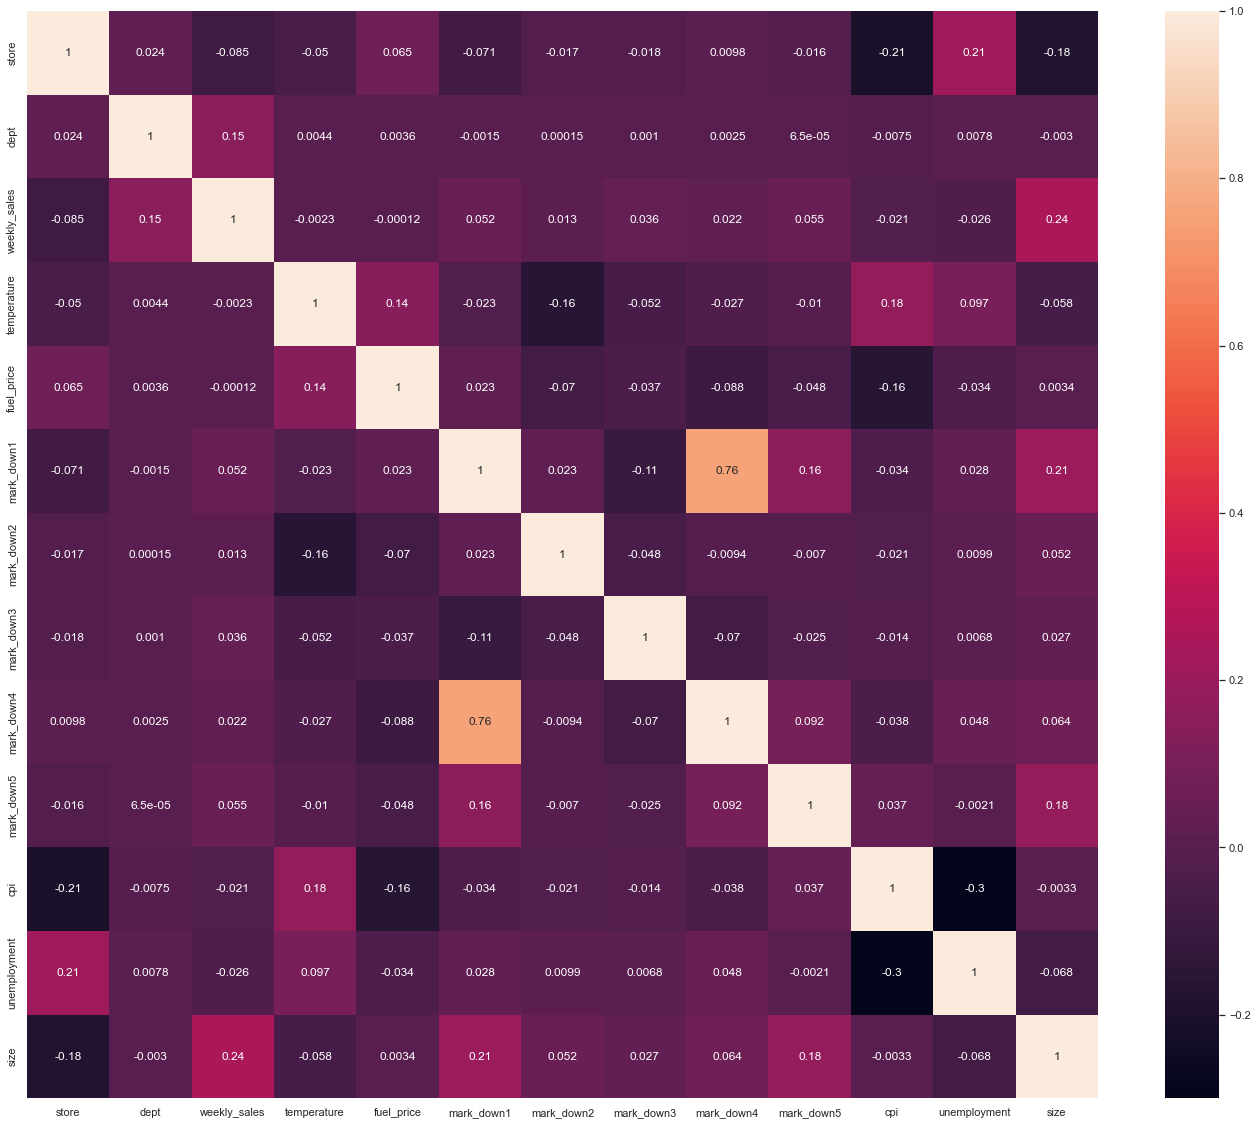

In [77]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True)

### 4.3.2 Categorical Attributes

In [78]:
a = df4.select_dtypes(include = 'object')

<AxesSubplot:>

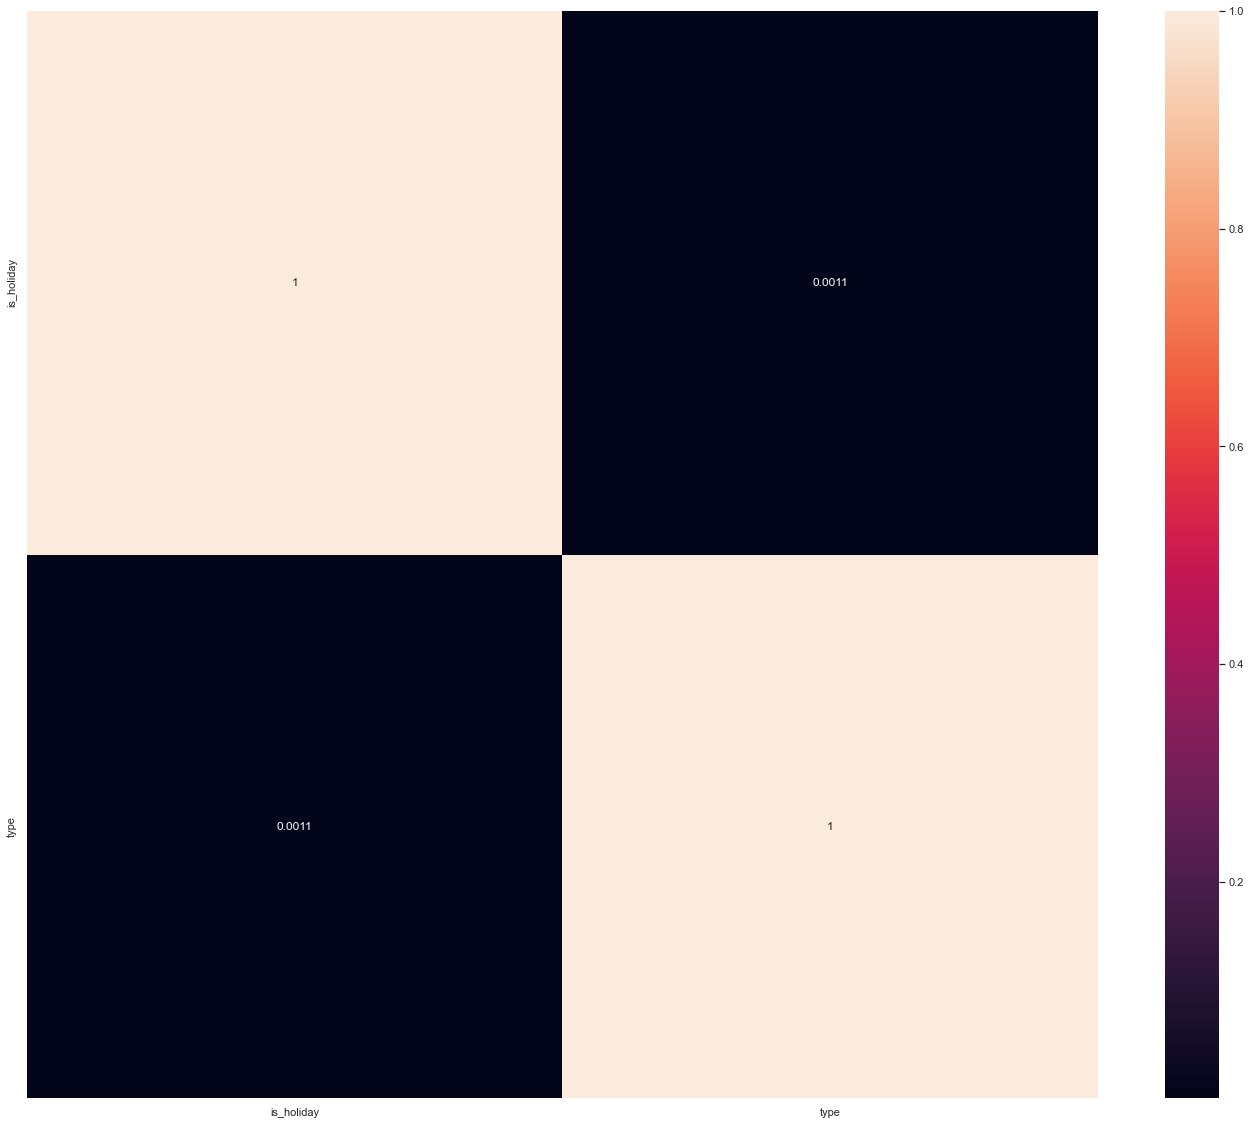

In [79]:
# only categorical data
a = df4.select_dtypes( include='object' )

# Calculate cramer V
a1 = cramer_v( a['is_holiday'], a['is_holiday'] ) 
a2 = cramer_v( a['is_holiday'], a['type'] ) 

a3 = cramer_v( a['type'], a['is_holiday'] )
a4 = cramer_v( a['type'], a['type'] )

# Final dataset
d = pd.DataFrame( {'is_holiday': [a1, a2],
                   'type':       [a3, a4]})
d = d.set_index( d.columns ) 
sns.heatmap( d, annot=True )

### 4.4 Resumo das Hipoteses

In [80]:
headers = ['Hipoteses', 'Conclusão', 'Relevância']
           
tab =[['H1', 'Verdadeira', 'Alta'],
      ['H2', 'Verdadeira', 'Alta'],
      ['H3', 'Verdadeira', 'Baixa'],
      ['H4', 'Falsa', 'Baixa'],
      ['H5', 'Falsa', 'Baixa'],
      ['H6', 'Verdadeira', 'Baixa'],
      ['H7', 'Verdadeira', 'Baixa']]
print( tabulate( tab, headers=headers, showindex="always"))

    Hipoteses    Conclusão    Relevância
--  -----------  -----------  ------------
 0  H1           Verdadeira   Alta
 1  H2           Verdadeira   Alta
 2  H3           Verdadeira   Baixa
 3  H4           Falsa        Baixa
 4  H5           Falsa        Baixa
 5  H6           Verdadeira   Baixa
 6  H7           Verdadeira   Baixa


# 5.0 PREPARAÇÃO DOS DADOS

In [81]:
df5 = df4.copy()

## 5.2 Scaling

In [82]:
mms = MinMaxScaler()
rs = RobustScaler()

# is_holiday
df5['is_holiday'] = df5['is_holiday'].apply(lambda x: 0 if x == False else 1)

# temperature 
df5['temperature'] = mms.fit_transform( df5[['temperature']].values )

# fuel_price 
df5['fuel_price'] = mms.fit_transform( df5[['fuel_price']].values )

# cpi
df5['cpi'] = mms.fit_transform( df5[['cpi']].values )

# unemployment 
df5['unemployment'] = mms.fit_transform( df5[['unemployment']].values )

# size 
df5['size'] = mms.fit_transform( df5[['size']].values )

# year 
df5['year'] = mms.fit_transform( df5[['year']].values )

# mark_down1
df5['mark_down1'] = mms.fit_transform( df5[['mark_down1']].values )

# mark_down1
df5['mark_down2'] = mms.fit_transform( df5[['mark_down2']].values )

# mark_down1
df5['mark_down3'] = mms.fit_transform( df5[['mark_down3']].values )

# mark_down1
df5['mark_down4'] = mms.fit_transform( df5[['mark_down4']].values )

# mark_down1
df5['mark_down5'] = mms.fit_transform( df5[['mark_down5']].values )


## 5.3 Transformação


### 5.3.1 Encoding

In [83]:
# is_holiday - One Hot Encoding
df5 = pd.get_dummies( df5, prefix=['is_holiday'], columns=['is_holiday'] )

# type - Label Encoder
le = LabelEncoder()
df5['type'] = le.fit_transform( df5['type'] )

### 5.3.2 Responsable Variable Transformation

In [84]:
df5['weekly_sales'] = np.log1p( df5['weekly_sales'] )

### 5.3.3. Nature Transformation

In [85]:
# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )                            

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x *  ( 2. * pi/30) ) )
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x *  ( 2. * pi/30) ) )

# 6.0 FEATURE SELECTION

In [86]:
df6 = df5.copy()

## 6.1 Split dataframe into train and test

In [87]:
cols_drop = ['date', 'weekly_sales', 'month', 'day', 'week_of_year']
df6 = df6.drop(cols_drop, axis = 1 )

In [88]:
X = df5.drop(cols_drop, axis=1)
y = df5['weekly_sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.30)

## 6.2 Boruta as Feature Selector

In [89]:
## training and test dataset for Boruta
#X_train_n = X_train.drop( ['date', 'weekly_sales'], axis=1 ).values
#y_train_n = y_train.values.ravel()

## define Boruta
#boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit(X_train_n, y_train_n )

#cols_selected = boruta.support_.tolist()

## best features
#X_train_fs = X_train.drop( ['date', 'weekly_sales'], axis=1 )

#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

## not selected boruta
#cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) )

## 6.3. Manual Feature Selection

In [90]:
#cols_selected_boruta = ['size']

#cols_selected_manual = [
#    'store',
#    'dept', 
#    'size']

# columns to add
#feat_to_add = ['date', 'weekly_sales']

#cols_selected_manual_full = cols_selected_manual.copy()
#cols_selected_manual_full.extend( feat_to_add )

In [92]:
#cols_selected_boruta = ['size']

# columns to add
#feat_to_add = ['date', 'weekly_sales']

#cols_selected_manual_full = cols_selected_manual.copy()
#cols_selected_manual_full.extend( feat_to_add )

## 6.4 Random Forest as Feature Selector

In [93]:
# feature importances 
#rf = RandomForestRegressor(n_jobs = -1, random_state = 42 ).fit(X_train, y_train)
#feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
#feat_importances.head(10).sort_values().plot(kind='barh')

cols_selected = ['mark_down5', 'mark_down4', 'mark_down2', 
                 'mark_down3', 'mark_down1', 'fuel_price', 
                 'temperature', 'cpi', 'store', 'dept']

# 7.0 MACHINE LEARNING MODELLING

In [94]:
X_train = X_train[ cols_selected ]
X_test = X_test[ cols_selected ]

## 7.1 Average Model

In [95]:
aux1 = X_test.copy()
aux1['weekly_sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'weekly_sales']].groupby( 'store' ).mean().reset_index().rename(columns={'weekly_sales': 'predictions'} )
aux1 = pd.merge( aux1, aux2, how='left', on='store' )
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error( 'Average Model',  y_test , yhat_baseline ) 
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1.416153,0.427784,1.885466


## 7.2 Linear Regression Model

In [110]:
# model
lr = LinearRegression().fit( X_train, y_train)

# prediction
yhat_lr = lr.predict( X_test )

# performance
lr_result = ml_error( 'Linear Regression',  y_test , yhat_lr  )
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1.51186,0.469115,1.985882


## 7.2.1 Linear Regression Model - Cross Validation

In [111]:
from sklearn.model_selection import cross_val_score, cross_validate

lr_cv = cross_validation( 'Linear Regression Model', lr, cv=5)
lr_cv

,Model Name,MAE,MAPE,RMSE
0,Linear Regression Model,-1.5127 +- 0.0033,-0.4363 +- 0.0511,-1.9861 +- 0.0039


## 7.3 Linear Regression Regularizared Lasso

In [112]:
# model
lrr = Lasso( alpha=0.01 ).fit( X_train, y_train )
# prediction
yhat_lrr = lrr.predict( X_test )
# performance
lrr_result = ml_error( 'Linear Regression - Lasso',  y_test,  yhat_lrr  )
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1.520758,0.472512,1.998728


## 7.3.1 Linear Regression Regularizared Lasso - Cross VAlidation

In [125]:
lrr_cv = cross_validation( 'Linear Regression Model - Lasso', lrr, cv=5)
lrr_cv

,Model Name,MAE,MAPE,RMSE
0,Linear Regression Model - Lasso,-1.521 +- 0.0037,-0.4384 +- 0.0513,-1.9981 +- 0.004


## 7.4. Random Forest Regressor 

In [116]:
# model
rf = RandomForestRegressor( n_jobs=-1, random_state=42 ).fit(X_train, y_train )
# prediction
yhat_rf = rf.predict( X_test )
# performance
rf_result = ml_error( 'Random Forest Regressor', y_test , yhat_rf  )
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,0.21739,0.087075,0.42305


## 7.4.1. Random Forest Regressor - Cross Validation

In [118]:
rf_cv = cross_validation( 'Random Forest Regressor', rf, cv=5)
rf_cv

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,-0.2258 +- 0.0011,-0.0952 +- 0.0167,-0.4379 +- 0.005


##  7.4 XGBoost Regressor

In [119]:
# model
model_xgb = xgb.XGBRegressor(n_jobs=-1, random_state=42).fit( X_train, y_train )

# prediction
yhat_xgb = model_xgb.predict( X_test )

# performance
xgb_result = ml_error( 'XGBoost Regressor', y_test , yhat_xgb  )
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,0.401871,0.139377,0.663154


## 7.4.1 XGBoost Regressor - Cross Validation

In [120]:
xgb_cv = cross_validation( 'XGBoost Regressor', model_xgb, cv=5)
xgb_cv

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,-0.4048 +- 0.0036,-0.1398 +- 0.0221,-0.6648 +- 0.0072


## 7.5 Compare Model's Perfomance

## 7.5.1. Single Performance

In [129]:
modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result] )
modelling_result.sort_values( 'RMSE' )

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,0.217390,0.087075,0.423050
0,XGBoost Regressor,0.401871,0.139377,0.663154
0,Average Model,1.416153,0.427784,1.885466
0,Linear Regression,1.511860,0.469115,1.985882
0,Linear Regression - Lasso,1.520758,0.472512,1.998728


##   7.5.2. Real Performance - Cross Validation

In [132]:
modelling_result_cv = pd.concat( [lr_cv, lrr_cv, rf_cv, xgb_cv] )
modelling_result_cv.sort_values( 'RMSE', ascending= True)

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,-0.2258 +- 0.0011,-0.0952 +- 0.0167,-0.4379 +- 0.005
0,XGBoost Regressor,-0.4048 +- 0.0036,-0.1398 +- 0.0221,-0.6648 +- 0.0072
0,Linear Regression Model,-1.5127 +- 0.0033,-0.4363 +- 0.0511,-1.9861 +- 0.0039
0,Linear Regression Model - Lasso,-1.521 +- 0.0037,-0.4384 +- 0.0513,-1.9981 +- 0.004


# 8.0 HYPERPARAMETER FINE TUNING

## 8.1 Random Search 

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

#define model
rf = RandomForestRegressor(n_jobs = -1, random_state = 42)

n_estimators = [5,20,50,100] # number of trees in the random forest
max_features = ['auto', 'sqrt'] # number of features in consideration at every split
max_depth = [int(x) for x in np.linspace(10, 120, num = 12)] # maximum number of levels allowed in each decision tree
min_samples_split = [2, 6, 10] # minimum sample number to split a node
min_samples_leaf = [1, 3, 4] # minimum sample number that can be stored in a leaf node
bootstrap = [True, False] # method used to sample data points

random_grid = {'n_estimators': n_estimators,

'max_features': max_features,

'max_depth': max_depth,

'min_samples_split': min_samples_split,

'min_samples_leaf': min_samples_leaf,

'bootstrap': bootstrap}

#define RandomSearchCV
rf_random_cv = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,
                               n_iter = 100, cv = 5, verbose=2, random_state=35, n_jobs = -1)

#fit RandomSearchCV
rf_random_cv.fit(X_train, np.ravel(y_train))

Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [ ]:
#get the best parameters to our model
rf_random_cv.best_estimator_

## 8.2 Final Model

# 9.0 TRADUÇÃO E INTERPRETAÇÃO DO ERRO

In [176]:
df9 = X_test[ cols_selected ]

#rescale
df9['weekly_sales'] = df5['weekly_sales'] 
df9['predictions'] =  yhat_rf
df9['date'] = df5['date']

##  9.1. Business Performance

In [177]:
# sum of predictions
df91 = df9[['store', 'predictions']].groupby( 'store' ).sum().reset_index()
# MAE and MAPE
df9_aux1 = df9[['store', 'weekly_sales', 'predictions']].groupby( 'store' ).apply(lambda x: mean_absolute_error( x['weekly_sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAE'})
df9_aux2 = df9[['store', 'weekly_sales', 'predictions']].groupby( 'store' ).apply(lambda x: mean_absolute_percentage_error( x['weekly_sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAPE'})
# Merge
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store' )
df92 = pd.merge( df91, df9_aux3, how='inner', on='store' )
# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']
# order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]


In [178]:
df92.sort_values('MAPE', ascending=False).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
32,33,13109.930565,13109.656729,13110.204402,0.273836,0.255660
0,1,27418.814117,27418.618040,27419.010195,0.196077,0.161155
23,24,27383.987152,27383.798492,27384.175812,0.188660,0.152931
30,31,27100.267336,27100.059328,27100.475343,0.208007,0.152838
29,30,14872.393568,14872.102920,14872.684216,0.290648,0.150827


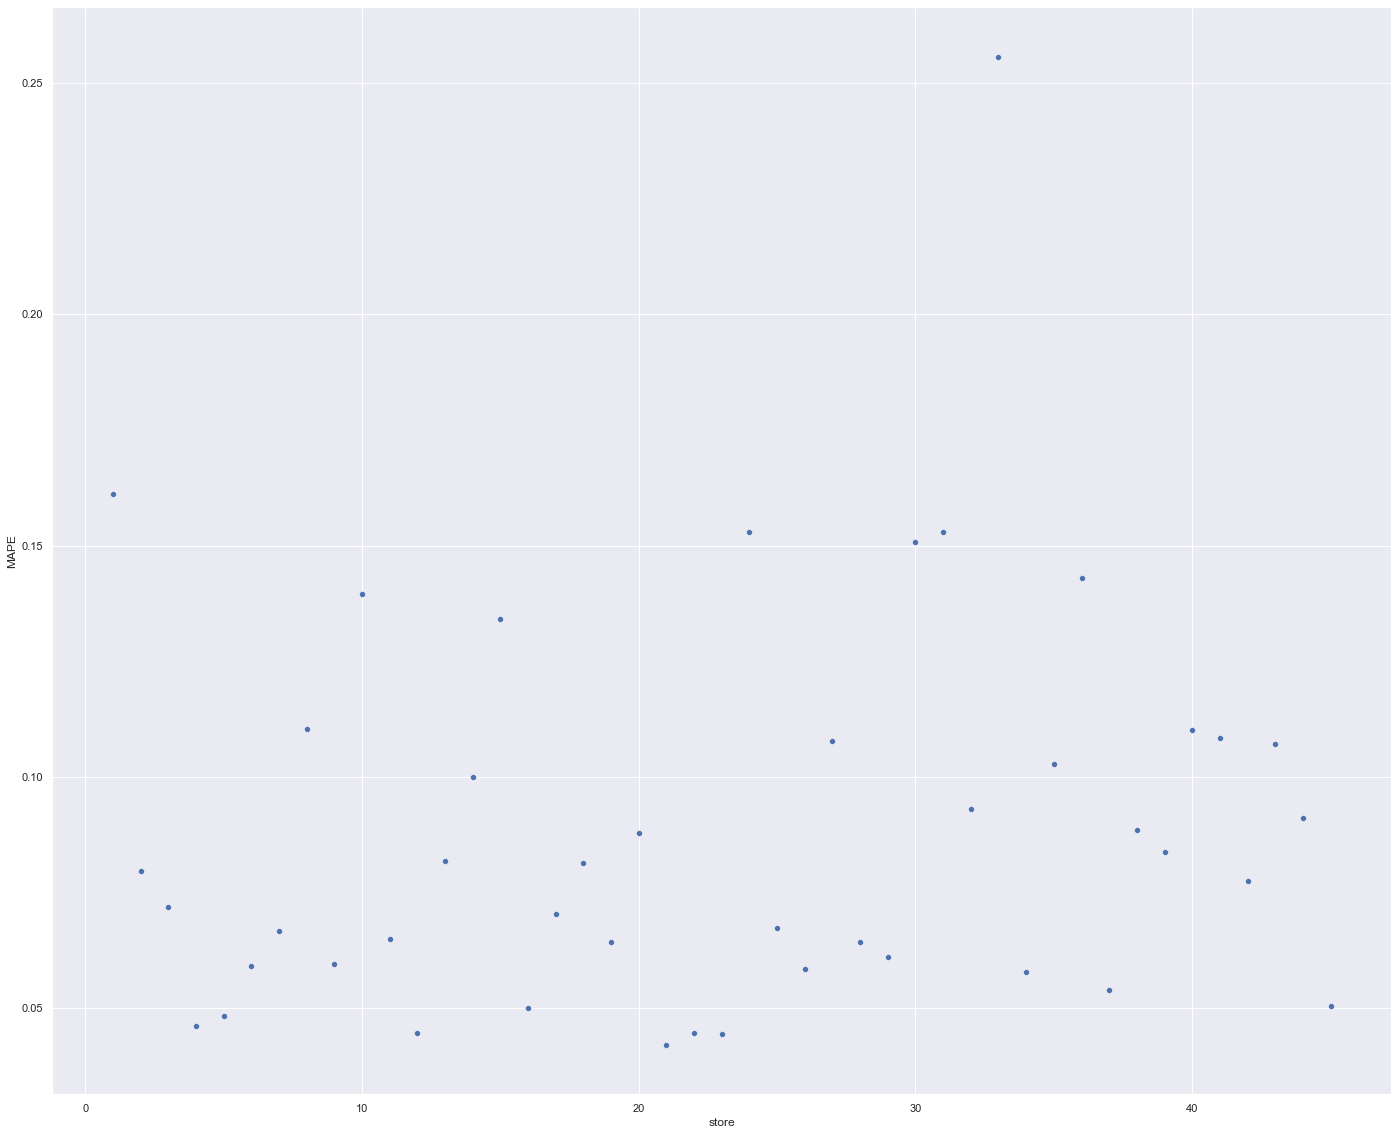

In [179]:
sns.scatterplot( x='store', y='MAPE', data=df92 );

##  9.2. Total Performance

In [180]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply( lambda x: np.sum( x ), axis=0 ).reset_index().rename( columns={'index': 'Scenario', 0:'Values'} )
df93['Values'] = df93['Values'].map( 'R${:,.2f}'.format )
df93

,Scenario,Values
0,predictions,"R$1,075,214.46"
1,worst_scenario,"R$1,075,204.56"
2,best_scenario,"R$1,075,224.36"


##  9.3. Machine Learning Performance

In [181]:
df9['error'] = df9['weekly_sales'] - df9['predictions'] 
df9['error_rate'] = df9['predictions'] / df9['weekly_sales']

<AxesSubplot:xlabel='predictions', ylabel='error'>

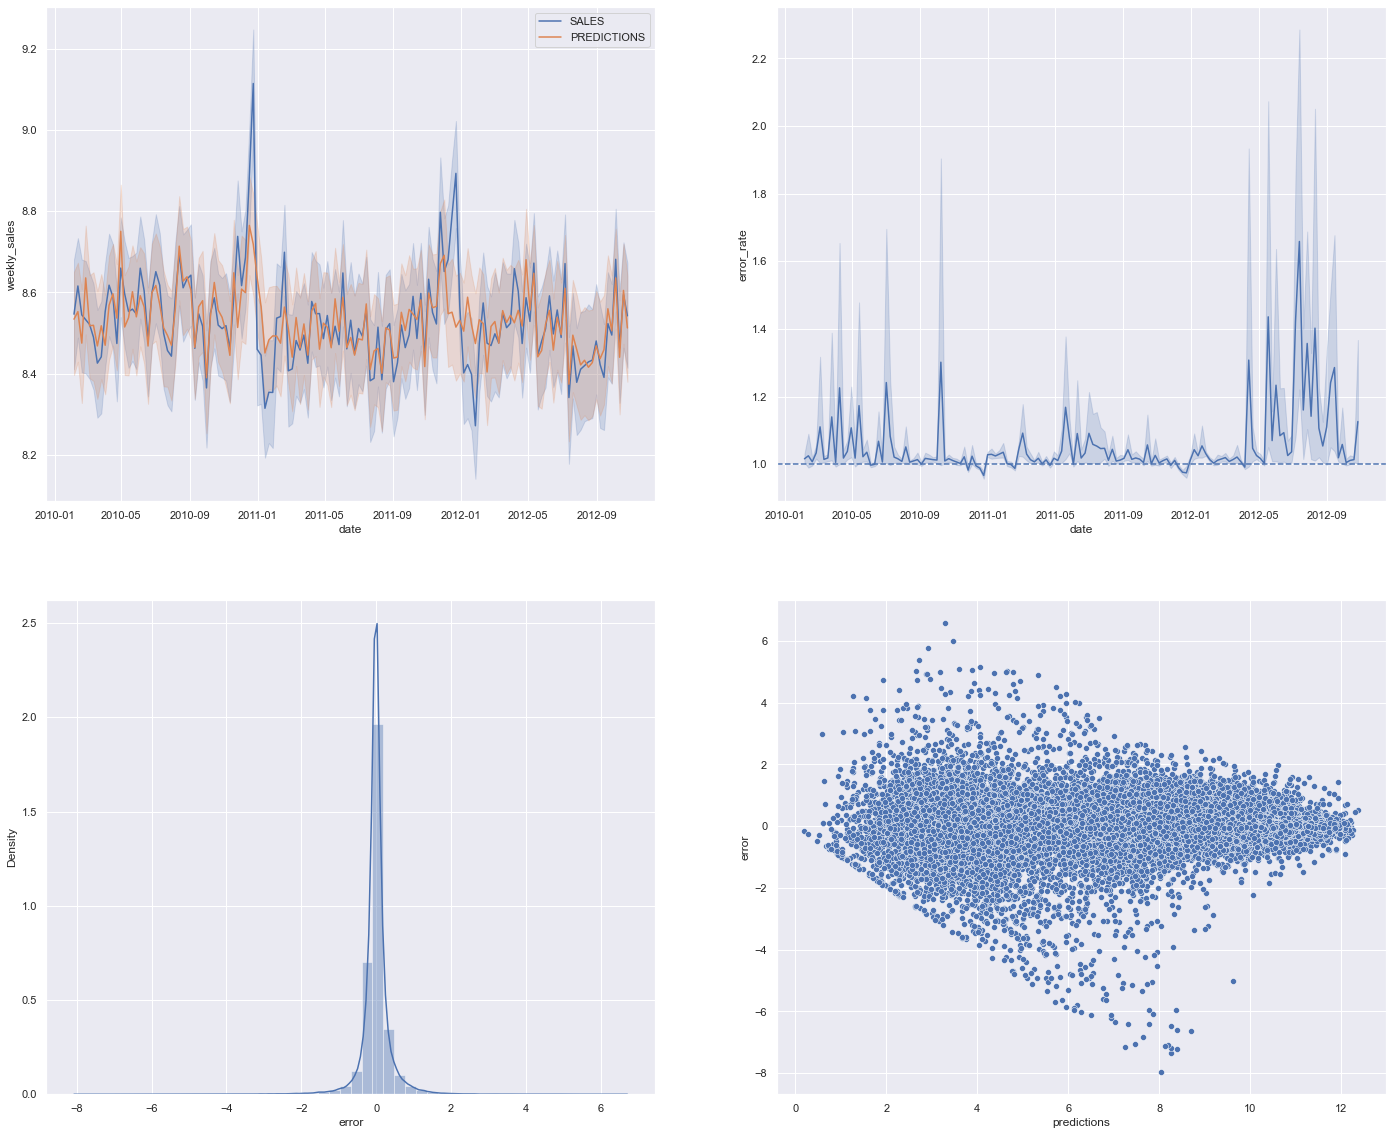

In [182]:
plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='weekly_sales', data=df9, label='SALES' )
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS' )

plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df9 )
plt.axhline( 1, linestyle='--')

plt.subplot( 2, 2, 3 )
sns.distplot( df9['error'] )

plt.subplot( 2, 2, 4 )
sns.scatterplot( df9['predictions'], df9['error'] )

# 10.0 DEPLOY MODEL TO PRODUCTION

In [187]:
filename = 'Walmart-Sales-Store-Forecasting-Model.pkl'
pickle.dump(rf_result_tuned, open(filename, 'wb'))